In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import auc
import os

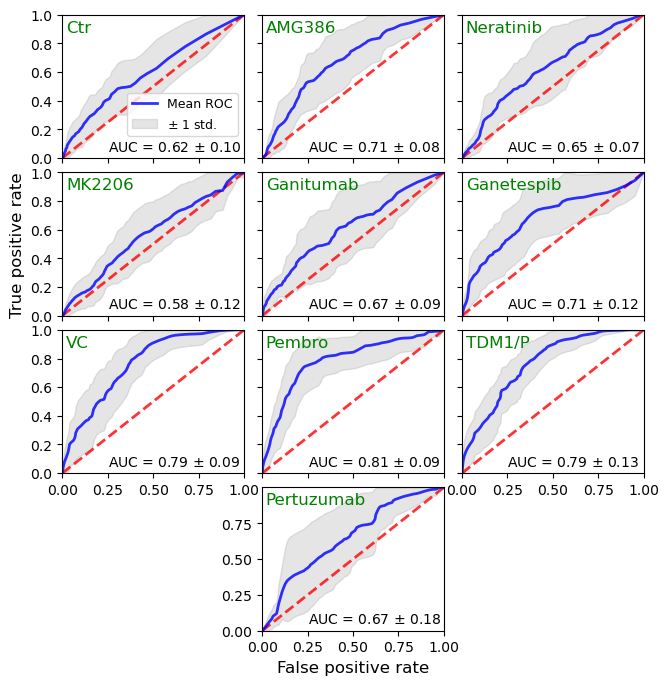

In [9]:
arm_short_name = ['Ctr', 'AMG386', 'N', 'MK2206', 'Ganitumab',  'Ganetespib', 'VC', 'Pembro', 'TDM1/P', 'Pertuzumab']
#arm_short_name = ['Pertuzumab']

fig, ax = plt.subplots(4,3, figsize = (7.5,8) )
mean_auc_all = []
directory_out = 'res_xgb35_analysis/'
try:
    os.mkdir(directory_out)
except FileExistsError:
    pass
    
for ai, a in enumerate(arm_short_name):
    if a == 'TDM1/P':
        b = 'TDM1P'
    else:
        b = a
    filename = 'res_xgb35/results_xgb35_hh1norm1_' + b + '_ftpr.csv'
    ftpr = pd.read_csv(filename, header = None)
    ftpr.columns = ['fpr', 'tpr', 'thresholds']

    tprs = []
    fprs = []
    aucs = []
    mean_probTh = np.linspace(0, 1, 101)
    run = ftpr.index[ftpr['fpr'] == 100].tolist()
    for i in range(len(run)+1):
        if i == 0:
            fpr=ftpr.iloc[:run[0],0].values
            tpr=ftpr.iloc[:run[0],1].values
            probTh = ftpr.iloc[:run[0],2].values
        elif i == len(run):
            fpr=ftpr.iloc[run[i-1]+1:ftpr.shape[0]+1,0].values
            tpr=ftpr.iloc[run[i-1]+1:ftpr.shape[0]+1,1].values
            probTh=ftpr.iloc[run[i-1]+1:ftpr.shape[0]+1,2].values
        else:
            fpr=ftpr.iloc[run[i-1]+1:run[i],0].values
            tpr=ftpr.iloc[run[i-1]+1:run[i],1].values
            probTh=ftpr.iloc[run[i-1]+1:run[i],2].values
        probTh[0]=1.0

        probTh = np.flip(probTh)
        tpr = np.flip(tpr)
        fpr = np.flip(fpr)
        
        interp_tpr = np.interp(mean_probTh,probTh, tpr)
        #interp_tpr[0] = 0.0
        tprs.append(interp_tpr)

        interp_fpr = np.interp(mean_probTh,probTh, fpr)
        #interp_fpr[0] = 0.0
        fprs.append(interp_fpr)
        
        aucs.append(auc(interp_fpr,interp_tpr))

    mean_tpr = np.mean(tprs, axis=0)
    std_tpr = np.std(tprs, axis=0)
    mean_fpr = np.mean(fprs, axis=0)
    std_fpr = np.std(fprs, axis =0)
    #mean_auc = auc(mean_fpr,mean_tpr)
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)

    temp = np.array([mean_tpr, mean_fpr, mean_probTh, std_tpr, std_fpr])
    tfpr = pd.DataFrame(temp.T, columns =['tpr','fpr','prob_threshold', 'tpr_std', 'fpr_std'])
    
    r, c = ai//3, ai%3
    if r == 3:
        c +=1
    ax[r, c].plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", alpha=0.8)
    ax[r, c].plot(
         mean_fpr,
         mean_tpr,
         color="b",
         label = r"Mean ROC", 
         lw=2,
         alpha=0.8,
    )

    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax[r, c].fill_between(
         mean_fpr,
         tprs_lower,
         tprs_upper,
         color="grey",
         alpha=0.2,
         label=r"$\pm$ 1 std.",
    )

    ax[r, c].set(
         xlim=[0, 1],
         ylim=[0, 1]
         #title="Receiver operating characteristic example",
    )
    ft = 12
    if r < 3:
        plt.yticks(fontsize=ft)
    else:
        ax[r,c].set_yticks([0, 0.25, 0.50, 0.75])

    if r == 1 and c == 0:
        ax[r,c].set_ylabel("True positive rate", fontsize = ft)

    if r == 3 and c == 1:
        ax[r,c].set_xlabel("False positive rate", fontsize = ft)
    
    if r != 3 and c != 0: 
        ax[r,c].set_yticklabels([])
    
    if r < 2: 
        ax[r,c].set_xticklabels([])
    if r == 2 and c == 1: 
        ax[r,c].set_xticklabels([])
    
    ax[r,c].text(0.25, 0.05,r"AUC = %0.2f $\pm$ %0.2f" % (mean_auc, std_auc))
    if r == 0 and c ==0: 
        ax[r,c].legend(loc='upper right', bbox_to_anchor=(1, 0.5), fontsize = 9) 
    
    #ax[ai//3, ai%3].legend(loc="lower right",fontsize = 10)

    if a == 'N':
        a = 'Neratinib'
    ax[r, c].text(0.02, 0.88, a,fontsize = ft, color = 'g')


    tfpr = np.round(tfpr,4)
    filename = directory_out + 'tfpr_' + b +'.csv'
    tfpr.to_csv(filename)

    mean_auc_all.append([mean_auc, std_auc])


fig.delaxes(ax[3, 0])
fig.delaxes(ax[3, 2])
fig.subplots_adjust(wspace=0.1, hspace=0.1)

filename = directory_out + 'fig_roc.png'
plt.savefig(filename)
    


In [10]:
mean_auc_all = pd.DataFrame(mean_auc_all, columns = ['auc_mean', 'auc_std'])
mean_auc_all.index = arm_short_name
mean_auc_all = np.round(mean_auc_all,4)
mean_auc_all.to_csv(directory_out + 'all_auc.csv')